## Assignment 3: Detecting Spam

### Imports

Python imports:

In [39]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, TextVectorization
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix




import warnings

warnings.filterwarnings('ignore')

#### Data import

In [40]:
data = pd.read_csv('Spam_SMS.csv')
data

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


We have 5574 data entries, each having a message and a class (being either HAM or SPAM)

### Data Exploration

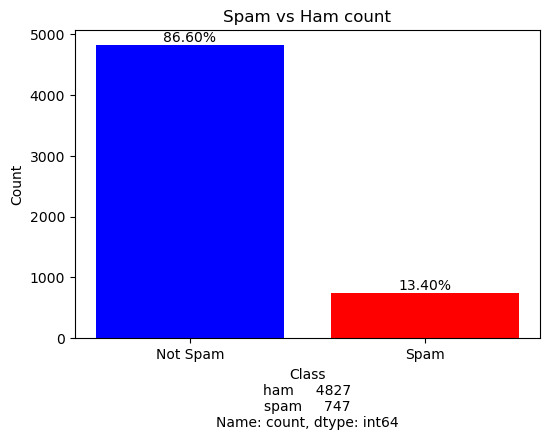

In [41]:
label_counts = data['Class'].value_counts()

# Get label counts as percentages
percentages = (label_counts / label_counts.sum()) * 100

# Plot percentages as figure
plt. figure(figsize=(6, 4))
bars = plt.bar(['Not Spam', 'Spam'], label_counts, color=['blue', 'red'])
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2, # X-coord = center ofthe bar
        bar.get_height(),
        f'{percentage:.2f}%', # Label with 2 decimal places
        ha = 'center',
        va = 'bottom'
    )

plt.title('Spam vs Ham count')
plt.ylabel('Count')
plt.xlabel(f'{label_counts}')
plt.show()


The data-set contains 4827 entries of ham (non-spam), and 747 entries that are spam. This corresponds to 86.6% and 13.4%, accordingly.

Before further exploration, all text is set to lowercase

In [42]:
def text_to_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(text_to_lowercase)

#### Most common words in HAM messages

In [43]:
# Frequency of words in HAM messages:

ham_words = ' '.join(data[data['Class'] == 'ham']['Message'])
ham_word_list = ham_words.split()
ham_word_count = Counter(ham_word_list)

# The 20 most common
most_common_ham = ham_word_count.most_common(20)
h_words, h_counts = zip(*most_common_ham)

Plotting the most common words in ham messages:

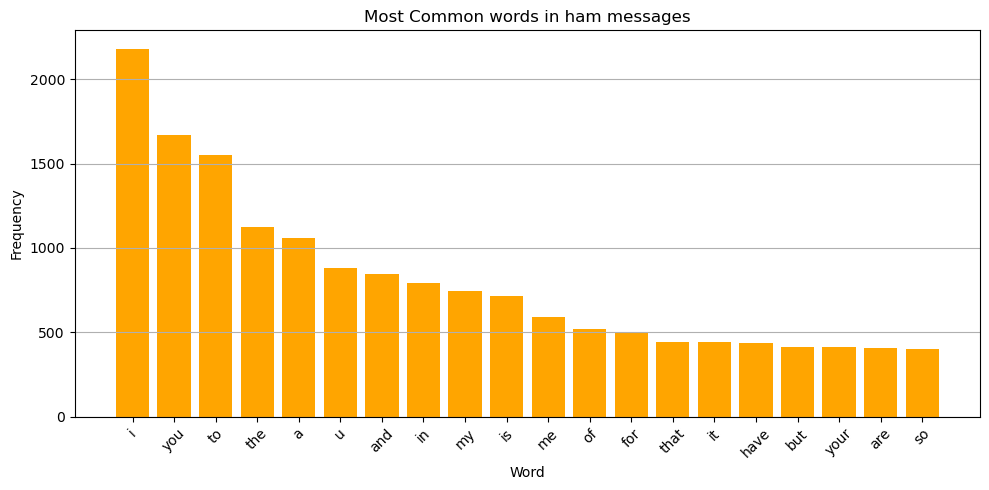

In [44]:
plt.figure(figsize=(10, 5))
plt.bar(h_words, h_counts, color='orange')
plt.title('Most Common words in ham messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-')
plt.tight_layout()

Lets plot the above as a WordCloud as well

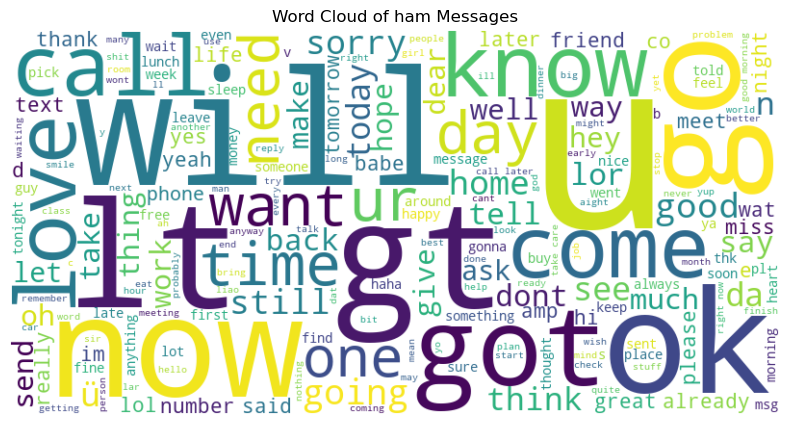

In [45]:
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of ham Messages')
plt.show()

#### Most common words in SPAM messages

In [46]:
# Frequency of words in SPAM messages:

spam_words = ' '.join(data[data['Class'] == 'spam']['Message'])
spam_word_list = spam_words.split()
spam_word_count = Counter(spam_word_list)

# The 20 most common
most_common_spam = spam_word_count.most_common(20)
s_words, s_counts = zip(*most_common_spam)

Plotting the most common words in spam messages:

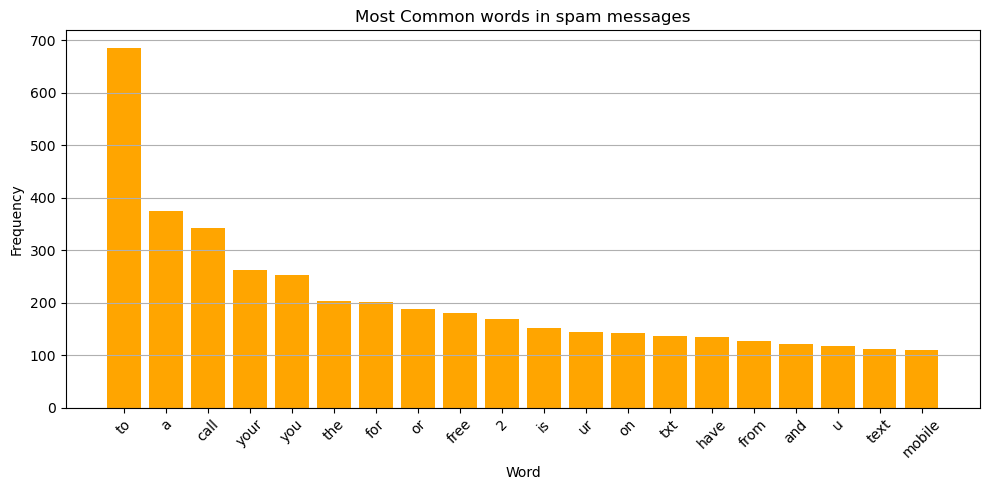

In [47]:
plt.figure(figsize=(10, 5))
plt.bar(s_words, s_counts, color='orange')
plt.title('Most Common words in spam messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-')
plt.tight_layout()

Lets plot the above as a WordCloud as well

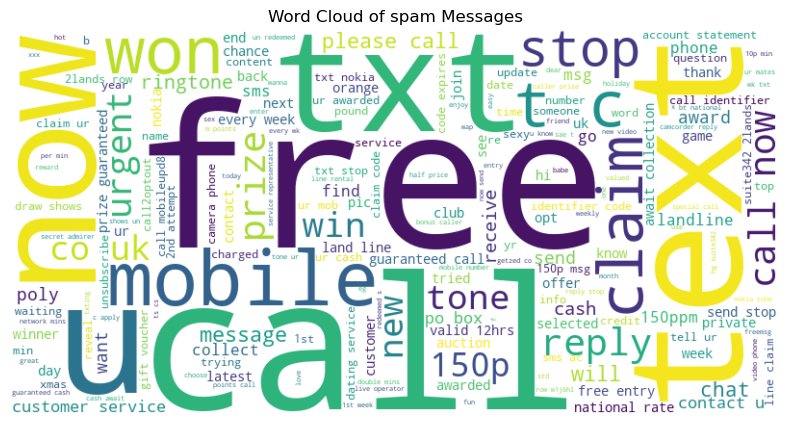

In [48]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of spam Messages')
plt.show()

### Preparation

The data is split up into X (data) and Y (class):

In [49]:
X = data.drop('Class', axis=1)
Y = data['Class']

#### Labelencoding
- 1: Spam
- 0: Ham

In [50]:
Y[:10]

0     ham
1     ham
2    spam
3     ham
4     ham
5    spam
6     ham
7     ham
8    spam
9    spam
Name: Class, dtype: object

In [51]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1])

#### Split the data

In [52]:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.2, random_state=42)

In [53]:
np.shape(X_train), np.shape(X_val), np.shape(X_test)

((3567, 1), (892, 1), (1115, 1))

#### Vectorization Configuration

In [54]:
max_tokens = 10000  # maximum number of unique tokens
max_len = 1000       # maximum sequence length after padding

##### Word-based:

In [55]:
word_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int', 
    output_sequence_length=max_len
    )
word_vectorizer.adapt(X_train)

##### Character-based:

In [56]:
char_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    split='character',
    output_mode='int',
    output_sequence_length=max_len
)
char_vectorizer.adapt(X_train)

### Model Definitions

#### LSTM with word embeddings

In [57]:
def create_lstm_model():
    model = Sequential([
        word_vectorizer,
        Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

#### GRU with character embeddings

In [58]:
def create_gru_model():
    model = Sequential([
        char_vectorizer,
        Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
        GRU(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [59]:
def compile_model(model, adam_or_adamW):
    if adam_or_adamW == 'adamW':
        optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
    else:
        optimizer = 'adam'

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', Precision(name='Precision')])
    return model

#### Callbacks

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

#### Instantiate Models

In [61]:
lstm_model = compile_model(create_lstm_model(), 'adam')
gru_model = compile_model(create_lstm_model(), 'adam')

### Model Training

In [62]:
history_lstm = lstm_model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10


112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 382ms/step - Precision: 0.5197 - accuracy: 0.8701 - loss: 0.4365 - val_Precision: 0.9615 - val_accuracy: 0.9798 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 383ms/step - Precision: 0.9854 - accuracy: 0.9926 - loss: 0.0455 - val_Precision: 0.9537 - val_accuracy: 0.9821 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - Precision: 0.9983 - accuracy: 0.9973 - loss: 0.0132 - val_Precision: 0.9381 - val_accuracy: 0.9832 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 394ms/step - Precision: 0.9976 - accuracy: 0.9984 - loss: 0.0077 - val_Precision: 0.9545 - val_accuracy: 0.9843 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 440ms/step - Precision: 1.0000 - accuracy: 0.9998 - loss: 0.0022 - val_Precision: 0.9375 - val_accuracy: 0.9821 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 6/10
112/1

In [63]:
history_gru = gru_model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 424ms/step - Precision: 0.5379 - accuracy: 0.8627 - loss: 0.4213 - val_Precision: 0.8926 - val_accuracy: 0.9787 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 428ms/step - Precision: 0.9855 - accuracy: 0.9924 - loss: 0.0467 - val_Precision: 0.9459 - val_accuracy: 0.9832 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - Precision: 0.9945 - accuracy: 0.9958 - loss: 0.0169 - val_Precision: 0.8908 - val_accuracy: 0.9765 - val_loss: 0.0605 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 396ms/step - Precision: 0.9983 - accuracy: 0.9993 - loss: 0.0053 - val_Precision: 0.9052 - val_accuracy: 0.9776 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 394ms/step - Precision: 1.0000 - accuracy: 0.9997 - loss: 0.0030 - val_Precision: 0.9123 - val_accuracy: 0.9776 - val_loss: 0.0748 - learning_rate: 2.0000e-04


#### Model Evaluation

In [64]:
lstm_results = lstm_model.evaluate(X_test, Y_test)
gru_results = gru_model.evaluate(X_test, Y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - Precision: 0.9889 - accuracy: 0.9941 - loss: 0.0314
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - Precision: 0.9123 - accuracy: 0.9777 - loss: 0.0678


#### Predictions

In [65]:
# Predictions for evaluation
lstm_preds = (lstm_model.predict(X_test) > 0.5).astype("int32")
gru_preds = (gru_model.predict(X_test) > 0.5).astype("int32")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step


#### Metrics

In [66]:
# Metrics and Confusion Matrix
print("LSTM Model Classification Report")
print(classification_report(Y_test, lstm_preds))
print("\nGRU Model Classification Report")
print(classification_report(Y_test, gru_preds))

LSTM Model Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       954
           1       0.99      0.96      0.97       161

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115


GRU Model Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       954
           1       0.93      0.92      0.93       161

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### Plotting Results

In [67]:
def plot_training(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

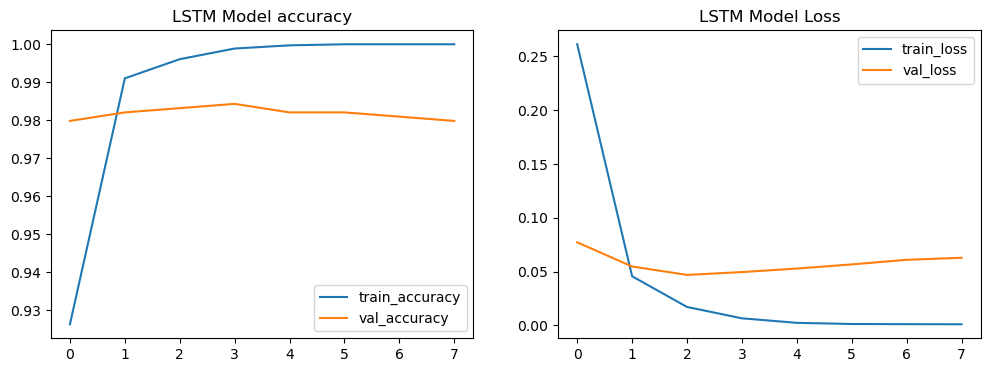

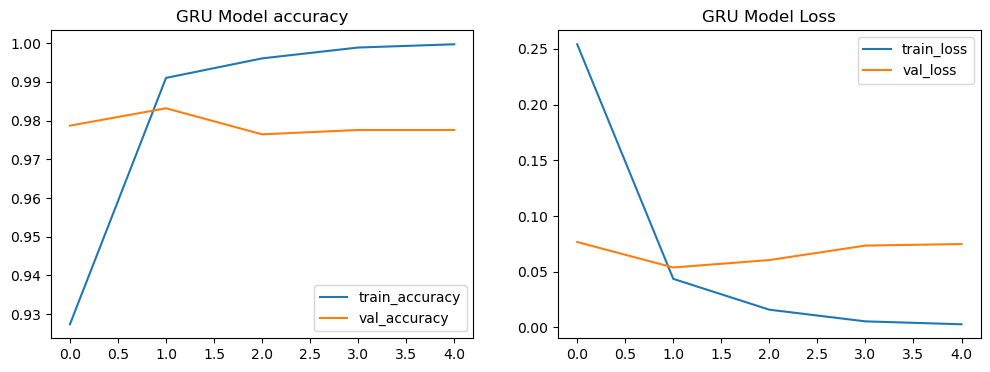

In [68]:
plot_training(history_lstm, "LSTM Model")
plot_training(history_gru, "GRU Model")

Let's try to use AdamW (with weight decay) as our optimizer instead of just Adam

In [69]:
lstm_model_adamW = compile_model(create_lstm_model(), 'adamW')
gru_model_adamW = compile_model(create_lstm_model(), 'adamW')

In [70]:
history_lstm_adamW = lstm_model_adamW.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step - Precision: 0.5452 - accuracy: 0.8711 - loss: 0.4296 - val_Precision: 0.9792 - val_accuracy: 0.9753 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - Precision: 0.9913 - accuracy: 0.9921 - loss: 0.0376 - val_Precision: 0.9459 - val_accuracy: 0.9832 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - Precision: 0.9894 - accuracy: 0.9957 - loss: 0.0185 - val_Precision: 0.9623 - val_accuracy: 0.9821 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - Precision: 0.9970 - accuracy: 0.9994 - loss: 0.0051 - val_Precision: 0.9626 - val_accuracy: 0.9832 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0026 - val_Precision: 0.9626 - val_accuracy: 0.9832 - val_loss: 0.0645 - learning_rate: 0.0010


In [71]:
history_gru_adamW = gru_model_adamW.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 371ms/step - Precision: 0.5548 - accuracy: 0.8823 - loss: 0.4294 - val_Precision: 0.9455 - val_accuracy: 0.9821 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - Precision: 0.9912 - accuracy: 0.9908 - loss: 0.0504 - val_Precision: 0.9145 - val_accuracy: 0.9809 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - Precision: 0.9965 - accuracy: 0.9981 - loss: 0.0135 - val_Precision: 0.9709 - val_accuracy: 0.9809 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - Precision: 0.9973 - accuracy: 0.9980 - loss: 0.0122 - val_Precision: 0.9138 - val_accuracy: 0.9798 - val_loss: 0.0676 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - Precision: 1.0000 - accuracy: 0.9994 - loss: 0.0030 - val_Precision: 0.9292 - val_accuracy: 0.9809 - val_loss: 0.0692 - learning_rate: 2.0000e-04


In [72]:
lstm_results_adamW = lstm_model_adamW.evaluate(X_test, Y_test)
gru_results_adamW = gru_model_adamW.evaluate(X_test, Y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - Precision: 0.9973 - accuracy: 0.9866 - loss: 0.0586
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - Precision: 0.9895 - accuracy: 0.9908 - loss: 0.0484


In [73]:
# Predictions for evaluation
lstm_preds_adamW = (lstm_model_adamW.predict(X_test) > 0.5).astype("int32")
gru_preds_adamW = (gru_model_adamW.predict(X_test) > 0.5).astype("int32")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


In [74]:
# Metrics and Confusion Matrix
print("LSTM Model Classification Report (AdamW)")
print(classification_report(Y_test, lstm_preds_adamW))
print("\nGRU Model Classification Report (AdamW)")
print(classification_report(Y_test, gru_preds_adamW))

LSTM Model Classification Report (AdamW)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.99      0.87      0.93       161

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115


GRU Model Classification Report (AdamW)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       954
           1       0.99      0.92      0.95       161

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



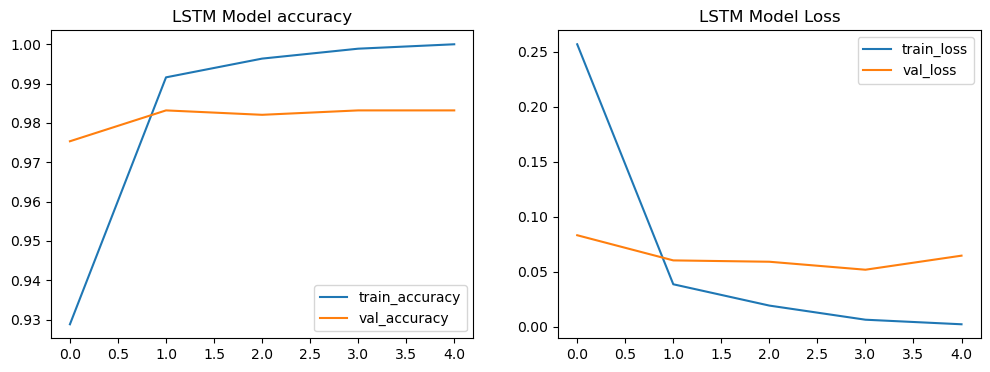

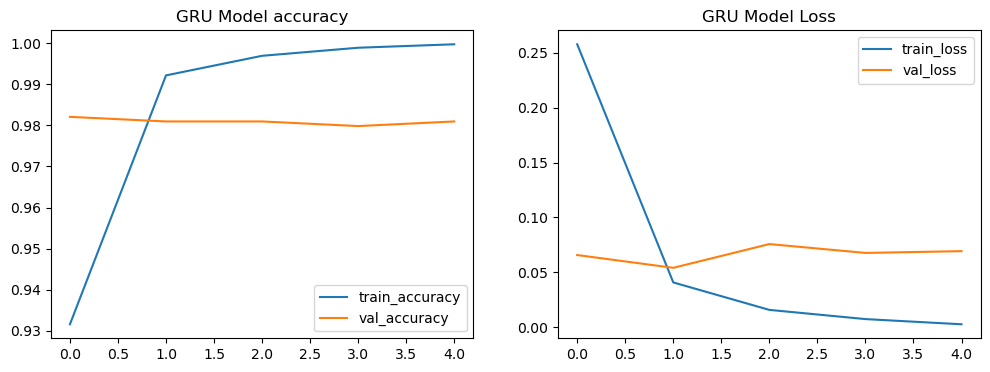

In [75]:
plot_training(history_lstm_adamW, "LSTM Model")
plot_training(history_gru_adamW, "GRU Model")

### Confusion Matrix

In [76]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


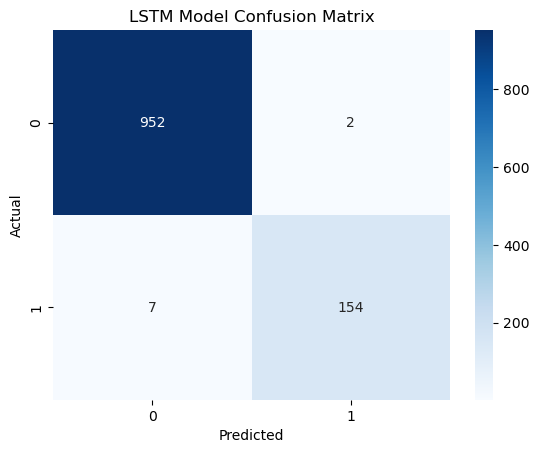

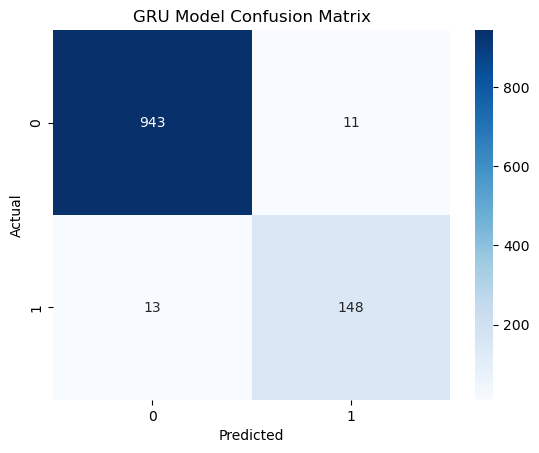

In [77]:
plot_confusion_matrix(Y_test, lstm_preds, "LSTM Model")
plot_confusion_matrix(Y_test, gru_preds, "GRU Model")

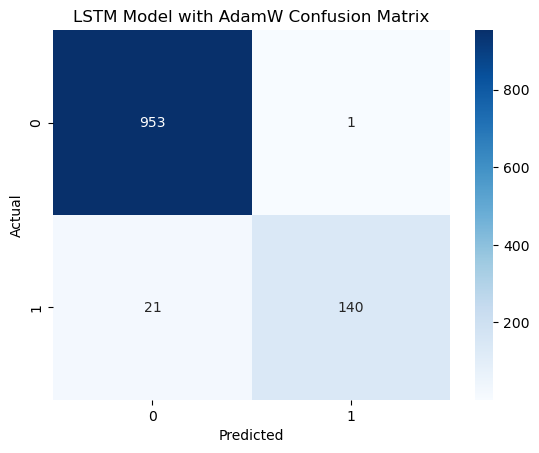

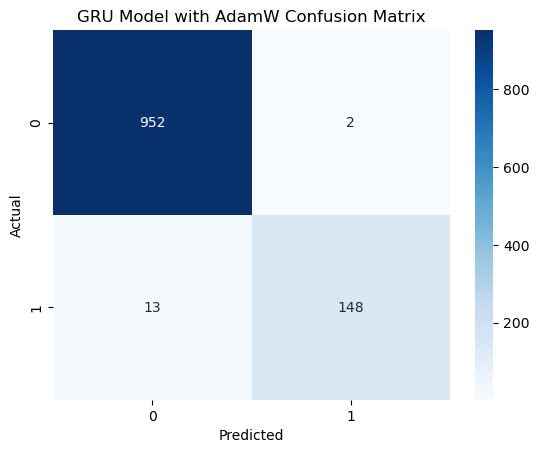

In [78]:
plot_confusion_matrix(Y_test, lstm_preds_adamW, "LSTM Model with AdamW")
plot_confusion_matrix(Y_test, gru_preds_adamW, "GRU Model with AdamW")